In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import random
import re
import os
import glob
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras import metrics
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras import losses
from skimage.transform import resize
from keras import backend as K
from skimage.transform import resize
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
#Limito la memoria de Tensorflow per poder utilitzar torch.
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
    memory_limit = 14233  # mb
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(
            gpu,
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])


In [2]:
#rutes
#image_dir = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat'
#mask_dir = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT'

#image_dir='/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat'
#mask_dir='/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT'

#image_dir='/kaggle/input/flood-area-segmentation/Image'
#mask_dir='/kaggle/input/flood-area-segmentation/Mask'
image_dir="/kaggle/input/semantic-segmentation-makassaridn-road-dataset/data_dataset_voc/JPEGImages"
mask_dir="/kaggle/input/semantic-segmentation-makassaridn-road-dataset/data_dataset_voc/SegmentationClassPNG"

In [3]:
#os.listdir(image_dir)

In [4]:
## Retallo les imatges per a que s'adequin al tamany necessari pel model.

image_list = []
resized_images = []

directory_path = image_dir

for filename in glob.glob(os.path.join(directory_path, '*.jpg')):
    #print(filename)
    img = Image.open(filename)
    image_list.append(img)

for image in image_list:
    image = image.resize((590,444))
    resized_images.append(image)

#output_directory = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/resized_images'
#output_directory ="/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/resized_images"
output_directory='/kaggle/working'
for (i, new) in enumerate(resized_images):
    new.save(os.path.join(output_directory, '{}{}.png'.format('resized_image', i+1)))


In [5]:
## Retallo les mascares per a que s'adequin al tamany necessari pel model.
masks_list = []
resized_masks = []

directory_path = mask_dir

for filename in glob.glob(os.path.join(directory_path, '*.png')):
    #print(filename)
    msk = Image.open(filename)
    masks_list.append(msk)

for mask in masks_list:
    mask = mask.resize((590,444))
    resized_masks.append(mask)

#output_directory = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/resized_masks'
#output_directory ="/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/resized_masks"
output_directory='/kaggle/working'

for (i, new) in enumerate(resized_masks):
    new.save(os.path.join(output_directory, '{}{}.png'.format('resized_mask', i+1)))



In [46]:
def load_images_and_masks(image_dir):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png") and "image" in filename:
            # Obtinc el numero d'imatge a partir del nom
            image_number = re.search(r'\d+', filename).group()

            # Carrego la imatge
            image_path = os.path.join(image_dir, filename)
            image = np.array(Image.open(image_path))

            # Carrego la mascara corresponent
            mask_filename = f"resized_mask{image_number}.png"
            mask_path = os.path.join(image_dir, mask_filename)
            mask = np.array(Image.open(mask_path).convert("L"))
            
            #Normalitzo les mascares
            mask = mask.reshape(mask.shape[0], mask.shape[1], 1) / 255.0

            # Guardo la imatge i la mascara en un diccionari
            images.append(image)
            masks.append(mask)
                
    return np.array(images),np.array(masks)



In [ ]:
# # Pels altres datasets!!

# def load_images_and_masks(image_dir,mask_dir):
#     images = []
#     masks = []
#     for filename in os.listdir(image_dir):
#         if filename.endswith(".jpg"): #and "image" in filename:
#             # Obtinc el numero d'imatge a partir del nom
#             image_number = re.search(r'\d+', filename).group()

#             # Carrego la imatge
#             image_filename=f"um_{image_number}.jpg"
#             image_path = os.path.join(image_dir, filename)
#             image = np.array(Image.open(image_path))

#             # Carrego la mascara corresponent
#             mask_filename = f"{image_number}.png"
#             mask_path = os.path.join(mask_dir, mask_filename)
#             mask = np.array(Image.open(mask_path).convert('L'))
            
#             #Normalitzo les mascares
#             mask = mask.reshape(mask.shape[0], mask.shape[1], 1) / 255.0
            
#             print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")


#             # Guardo la imatge i la mascara en un diccionari
#             images.append(image)
#             masks.append(mask)
                
#     return np.array(images),np.array(masks)

In [48]:
# # Ruta de les imatges
# #image_dir = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/resized_images/'
# #image_dir = "/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/resized_images"
image_dir='/kaggle/working'
#image_dir='/kaggle/input/semantic-segmentation-makassaridn-road-dataset/data_dataset_voc/JPEGImages'
#mask_dir='/kaggle/input/semantic-segmentation-makassaridn-road-dataset/data_dataset_voc/SegmentationClassPNG'
# Carrego les imatges
images,masks = load_images_and_masks(image_dir)


In [ ]:
# def load_masks(mask_dir):
#      masks = []

#      for filename in os.listdir(mask_dir):
#          if filename.endswith(".png") and "mask" in filename:
             
#              mask_path = os.path.join(mask_dir, filename)
#              mask = np.array(Image.open(mask_path).convert("L"))
#              normalized_mask=mask/255.0
             
#              masks.append(normalized_mask)
#      return np.array(masks)



In [ ]:
# # Ruta de les mascares
# #masks_dir = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/resized_masks'
# #masks_dir = "/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/resized_masks"
#masks_dir="/kaggle/working"


# Carrego les imatges
#masks = load_masks(masks_dir)

In [49]:
# #Ajusto les imatges
# #adjusted_images = images.reshape(-1, 590, 444, 3)
masks = masks.reshape(-1, masks.shape[1], masks.shape[2], 1)

In [50]:
images.shape

(374, 444, 590, 3)

In [51]:
masks.shape

(374, 444, 590, 1)

In [11]:
images_reshaped = images.reshape((-1, 444, 590, 3))
masks_reshaped = masks.reshape((-1, 444, 590, 1))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images_reshaped,masks_reshaped, test_size=0.2, random_state=23)


In [13]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
#Model
input_shape = (444,590, 3)
num_filters = 32


## Model més simple per mirar de solventar el problema de dimensions.
model = models.Sequential()
    
# Encoder
model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

    
# Decoder
model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef]) #dice coefficient

In [ ]:
#### PROVA MODEL MÉS COMPLEX
input_shape = (444, 590, 3)
num_filters = 32

model = models.Sequential()

# Encoder
model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Additional Encoder Layers
model.add(layers.Conv2D(2*num_filters, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))


# Decoder
model.add(layers.Conv2D(2*num_filters, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))


# Additional Decoder Layers
model.add(layers.Conv2DTranspose(num_filters, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.UpSampling2D((2, 2)))

model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])


In [14]:
input_shape = (444, 590, 3)
num_filters = 64

model = models.Sequential()

# Encoder
model.add(Conv2D(num_filters, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_filters, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Additional Encoder Layers
model.add(Conv2D(2*num_filters, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_filters, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Decoder
model.add(Conv2D(2*num_filters, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))


# Additional Decoder Layers
model.add(Conv2DTranspose(num_filters, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(num_filters, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(UpSampling2D((2, 2)))

# Output layer
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])


In [17]:
# Train the model
history=model.fit(X_train, y_train, epochs=20, batch_size=8,validation_data=(X_test,y_test))


Epoch 1/20
38/38 [==============================] - 31s 814ms/step - loss: 0.0963 - dice_coef: 0.1019 - val_loss: 0.0981 - val_dice_coef: 0.0982
Epoch 2/20
38/38 [==============================] - 31s 818ms/step - loss: 0.0961 - dice_coef: 0.1023 - val_loss: 0.0984 - val_dice_coef: 0.0890
Epoch 3/20
38/38 [==============================] - 30s 798ms/step - loss: 0.0961 - dice_coef: 0.1026 - val_loss: 0.1030 - val_dice_coef: 0.0813
Epoch 4/20
38/38 [==============================] - 31s 806ms/step - loss: 0.0967 - dice_coef: 0.1014 - val_loss: 0.0974 - val_dice_coef: 0.0916
Epoch 5/20
38/38 [==============================] - 31s 808ms/step - loss: 0.0960 - dice_coef: 0.1027 - val_loss: 0.1011 - val_dice_coef: 0.0748
Epoch 6/20
38/38 [==============================] - 30s 803ms/step - loss: 0.0960 - dice_coef: 0.1023 - val_loss: 0.1022 - val_dice_coef: 0.0689
Epoch 7/20
38/38 [==============================] - 30s 803ms/step - loss: 0.0961 - dice_coef: 0.1027 - val_loss: 0.0973 - val_dic

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 444, 590, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 444, 590, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 444, 590, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 444, 590, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 444, 590, 64)      256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 444, 590, 64)      0

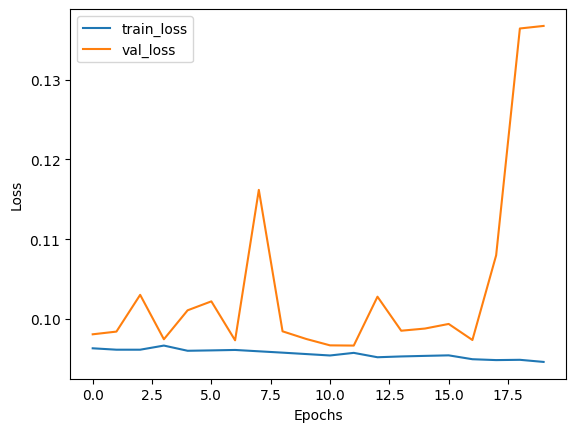

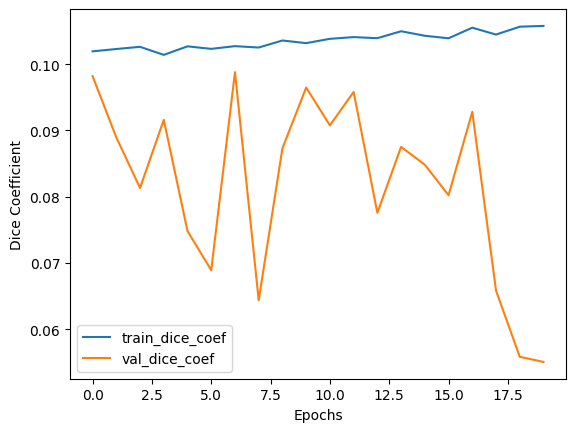

In [19]:
#Faig gràfics per veure com entrena el model
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['dice_coef'], label='train_dice_coef')
plt.plot(history.history['val_dice_coef'], label='val_dice_coef')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

[280, 147, 118, 205, 300]
1/1 [==============================] - 3s 3s/step


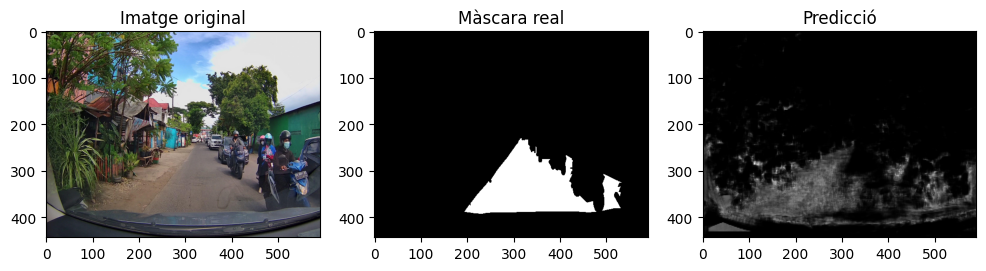

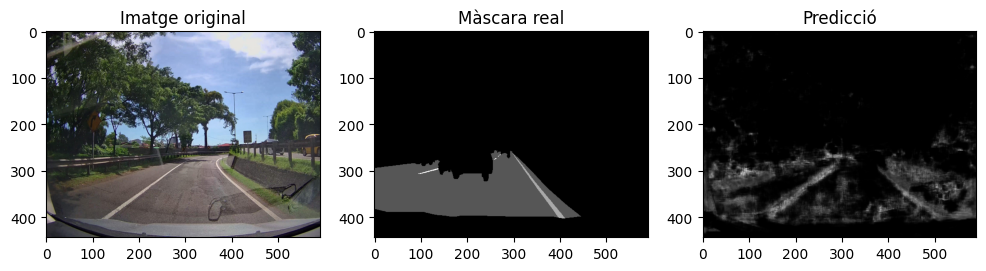

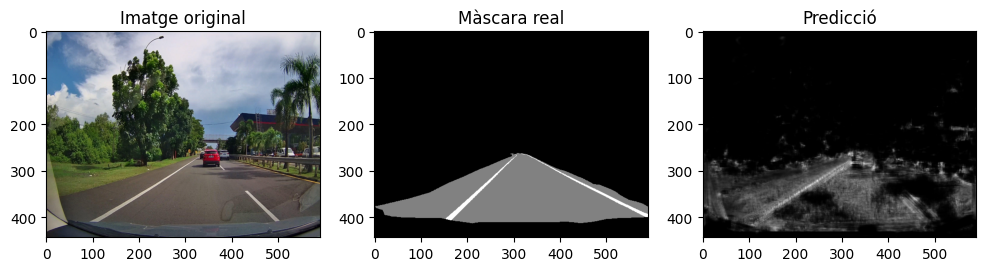

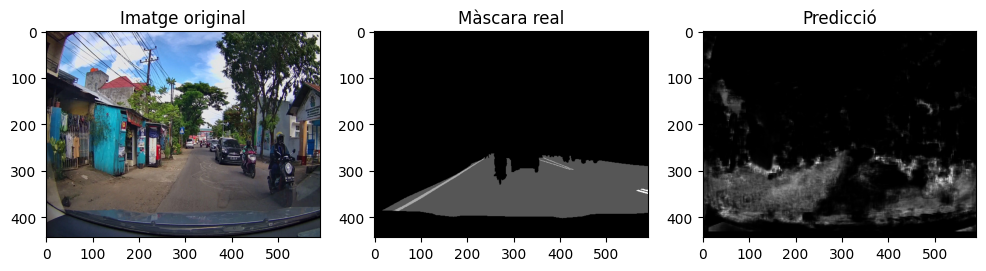

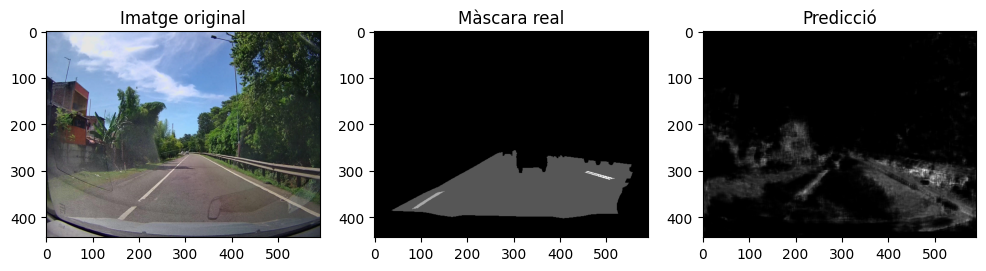

In [20]:
#comprovo com funciona el model
num_samples = 5
sample_indices = random.sample(range(len(images)), num_samples)
print(sample_indices)
sample_images = [images[i] for i in sample_indices]
sample_masks_true = [masks[i] for i in sample_indices]


sample_masks_pred = model.predict(np.array(sample_images))


for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    
    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i])
    plt.title('Imatge original')
    
   
    plt.subplot(1, 3, 2)
    plt.imshow(sample_masks_true[i][:, :, 0], cmap='gray')  
    plt.title('Màscara real')
    
    plt.subplot(1, 3, 3)
    plt.imshow(sample_masks_pred[i][:, :, 0], cmap='gray')  
    plt.title('Predicció')
    
    
    plt.show()
#component connexa

#200x200

In [ ]:
# SAM

In [ ]:
import os 
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2


HOME = os.getcwd()
print("HOME:", HOME)

%cd {HOME}

!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q supervision
import supervision as sv

In [ ]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

In [ ]:
# Carrego imatges de prova:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

In [ ]:

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"



sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)


In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

IMAGE_NAME = f"resized_image_{sample_indices[0]}.png"
IMAGE_PATH =f"/kaggle/working/resized_image{sample_indices[0]}.png"



image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [ ]:
print(sam_result[0].keys())

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show() 

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/kaggle/working/weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
masks_sam = mask_generator.generate(image_rgb)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
show_anns(masks_sam)
plt.axis('off')
plt.show() 

In [ ]:
###### PROVES VARIES###########

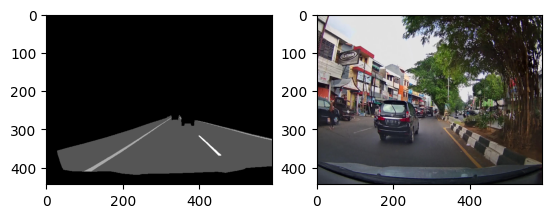

In [34]:
plt.subplot(1,2,1)
image = np.array(Image.open("/kaggle/working/resized_mask1.png"))
image.max()
plt.imshow(image,cmap="gray")
plt.subplot(1,2,2)
image = np.array(Image.open("/kaggle/working/resized_image5.png"))
image.max()
plt.imshow(image,cmap="gray")

In [ ]:

def load_images(image_dir):
    images = {}
    for filename in os.listdir(image_dir):
        if filename.endswith(".png") and "image" in filename:
            image_path = os.path.join(image_dir, filename)
            image = np.array(Image.open(image_path).convert("RGB"))
            normalized_image = image / 255.0
            image_key = filename.replace("_image.png", "")
            images[image_key] = {'image': normalized_image}

    return images

def load_masks(mask_dir):
    masks = {}
    for filename in os.listdir(mask_dir):
        if filename.endswith(".png") and "mask" in filename:
            mask_path = os.path.join(mask_dir, filename)
            mask = np.array(Image.open(mask_path).convert("L"))
            normalized_mask = mask / 255.0
            mask_key = filename.replace("_mask.png", "")
            masks[mask_key] = {'mask': normalized_mask}

    return masks

In [ ]:
# Buscar dataset més complex per entrenar ambdos arquitectures.
# Buscar com executar el sam en local i comprar models.